### Data Processing

#### Data Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram
%matplotlib inline

# Control the default size of figures in this Jupyter notebook
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)   # Change the size of plots

soil = pd.read_excel("data/Cody_soil_table.xlsx")
soil = soil.fillna(0)
soil = soil.transpose()
soil.head()

Populating the interactive namespace from numpy and matplotlib


,Hematite,Illmenite,Goethite,Magnetite,Quartz,Gibbsite,1:1 Clay,Maghemite,Carbonate Minerals,Plagioclase,2:1 Clays,Dolomite,Pyroxene,Calcite,Olivine,Glass,Interlayered Smectite,NTM Culture,Microbiome,Group
HNL 12-6,2.80702,0,4.08187,1.9883,0,0,6.78363,0.538012,38.5965,32.9825,0,0,6.4,0,5.1462,0,0,pos,1,Kitchen_sink
HNL 12-4,1.287,8.75161,7.72201,15.3153,7.72201,2.4453,33.3333,1.60875,21.879,0,0,0,0,0,0,0,0,pos,1,Laterite_carbonate
HNL 12-2,11.0457,3.24006,1.47275,0.206186,3.68189,7.65832,33.2842,0,21.0604,18.4094,0,0,0,0,0,0,0,pos,1,Laterite_carbonate_plagioclase
HNL 12-39,23.5402,7.22519,14.1907,2.86561,0.558272,7.94945,36.2554,7.41512,0,0,0,0,0,0,0,0,0,neg,1,Laterite
HNL 12-61,10.4787,3.44097,30.5982,12.063,5.16915,7.15495,24.8656,6.22948,0,0,0,0,0,0,0,0,0,neg,0,Laterite


#### Scale Column Values
This process is used to normalize the values for machine learning algorithms and for visualization purposes. 

In [62]:
## Split data into numeric and categorial categories
cols_to_drop = ["Interlayered Smectite", "NTM Culture", "Microbiome", "Group"]
soil_numeric = soil.drop(cols_to_drop, axis=1)
soil_categorical = soil.drop(soil.columns[0:16], axis=1)

## Store Columns and Index for later
cols = soil_numeric.columns
soil_index = soil_numeric.index

In [63]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
scaled_df = ss.fit_transform(soil_numeric)
scaled_df = pd.DataFrame(scaled_df, columns=cols)
scaled_df.index = soil_index

soil_scaled = pd.merge(scaled_df, soil_categorical, left_index=True, right_index=True)
soil_scaled.head()

,Hematite,Illmenite,Goethite,Magnetite,Quartz,Gibbsite,1:1 Clay,Maghemite,Carbonate Minerals,Plagioclase,2:1 Clays,Dolomite,Pyroxene,Calcite,Olivine,Glass,Interlayered Smectite,NTM Culture,Microbiome,Group
HNL 12-6,-1.087941,-0.711051,-0.785465,-0.562532,-0.663686,-1.061085,-1.180748,-0.939294,2.026242,1.270647,-0.224946,-0.138675,1.293156,-0.138675,7.211103,-0.138675,0,pos,1,Kitchen_sink
HNL 12-4,-1.302325,1.303546,-0.488427,2.324167,0.242599,-0.475294,0.289417,-0.686916,0.822668,-0.805106,-0.224946,-0.138675,-0.200790,-0.138675,-0.138675,-0.138675,0,pos,1,Laterite_carbonate
HNL 12-2,0.074044,0.034802,-0.998371,-0.948548,-0.231566,0.773525,0.286699,-1.066105,0.763730,0.353492,-0.224946,-0.138675,-0.200790,-0.138675,-0.138675,-0.138675,0,pos,1,Laterite_carbonate_plagioclase
HNL 12-39,1.836289,0.952168,0.039427,-0.372502,-0.598165,0.843268,0.451223,0.681667,-0.752513,-0.805106,-0.224946,-0.138675,-0.200790,-0.138675,-0.138675,-0.138675,0,neg,1,Laterite
HNL 12-61,-0.005918,0.081052,1.378287,1.619699,-0.057015,0.652938,-0.179476,0.402208,-0.752513,-0.805106,-0.224946,-0.138675,-0.200790,-0.138675,-0.138675,-0.138675,0,neg,0,Laterite


### Feature Correlation

In [ ]:
soil_categorical['NTM Culture'].replace(('pos', 'neg'), (1,0), inplace=True)
soil_response = list(soil_categorical['NTM Culture'])

In [78]:
from scipy import stats
correlation_pearson = []
names2 = []
for z in range(0, 16):
    value = stats.pointbiserialr(np.array(scaled_df[scaled_df.columns[z]]), soil_response)
    names2.append(scaled_df.columns[z])
    correlation_pearson.append(value)

In [97]:
Correlation = []
P_Value = []
x = [Correlation.append(x.correlation) for x in correlation_pearson]
x = [P_Value.append(x.pvalue) for x in correlation_pearson]
df_sig = pd.DataFrame(names2)
df_sig.columns = ['Soil_Minerals']
df_sig.set_index('Soil_Minerals')
df_sig['Correlation'] = Correlation
df_sig['P_Value'] = P_Value
df_sig

,Soil_Minerals,Correlation,P_Value
0,Hematite,-0.005063,0.971300
1,Illmenite,-0.101494,0.469594
2,Goethite,-0.001146,0.993504
3,Magnetite,-0.077142,0.582984
4,Quartz,-0.000531,0.996990
5,Gibbsite,-0.104926,0.454627
6,1:1 Clay,-0.144397,0.302270
7,Maghemite,-0.001471,0.991660
8,Carbonate Minerals,0.061898,0.659717
9,Plagioclase,0.196927,0.157553


In [11]:
def exact_mc_perm_test(xs, ys, nmc):
    n, k = len(xs), 0
    diff = np.abs(np.mean(xs) - np.mean(ys))
    zs = np.concatenate([xs, ys])
    for j in range(nmc):
        np.random.shuffle(zs)
        k += diff < np.abs(np.mean(zs[:n]) - np.mean(zs[n:]))
    return k / float(nmc)

xs = np.array([12.6, 11.4, 13.2, 11.2, 9.4, 12.0])
ys = np.array([16.4, 14.1, 13.4, 15.4, 14.0, 11.3])
exact_mc_perm_test(xs, ys, 30000)

0.019466666666666667

In [39]:
positive = soil_scaled[soil_scaled['NTM Culture']=='pos']
negative = soil_scaled[soil_scaled['NTM Culture']=='neg']

cols_to_drop = ["Interlayered Smectite", "NTM Culture", "Microbiome", "Group"]
positive = positive.drop(cols_to_drop, axis=1)
negative = negative.drop(cols_to_drop, axis=1)

my_list = []
my_columns = []
for z in range(0, len(positive)):
    p_value = exact_mc_perm_test(np.array(positive[positive.columns[z]]), np.array(negative[negative.columns[z]]), 1000)
    my_columns.append(negative.columns[z])
    my_list.append(p_value)

In [40]:
df = pd.DataFrame(my_columns)
df['Permutated p_values'] = my_list
df

,0,Permutated p_values
0,Hematite,0.969
1,Illmenite,0.481
2,Goethite,0.994
3,Magnetite,0.610
4,Quartz,0.996
5,Gibbsite,0.463
6,1:1 Clay,0.317
7,Maghemite,0.990
8,Carbonate Minerals,0.648
9,Plagioclase,0.165


#### Feature Heatmap

Text(0.5,0.98,'Soil Attributes Correlation Heatmap')

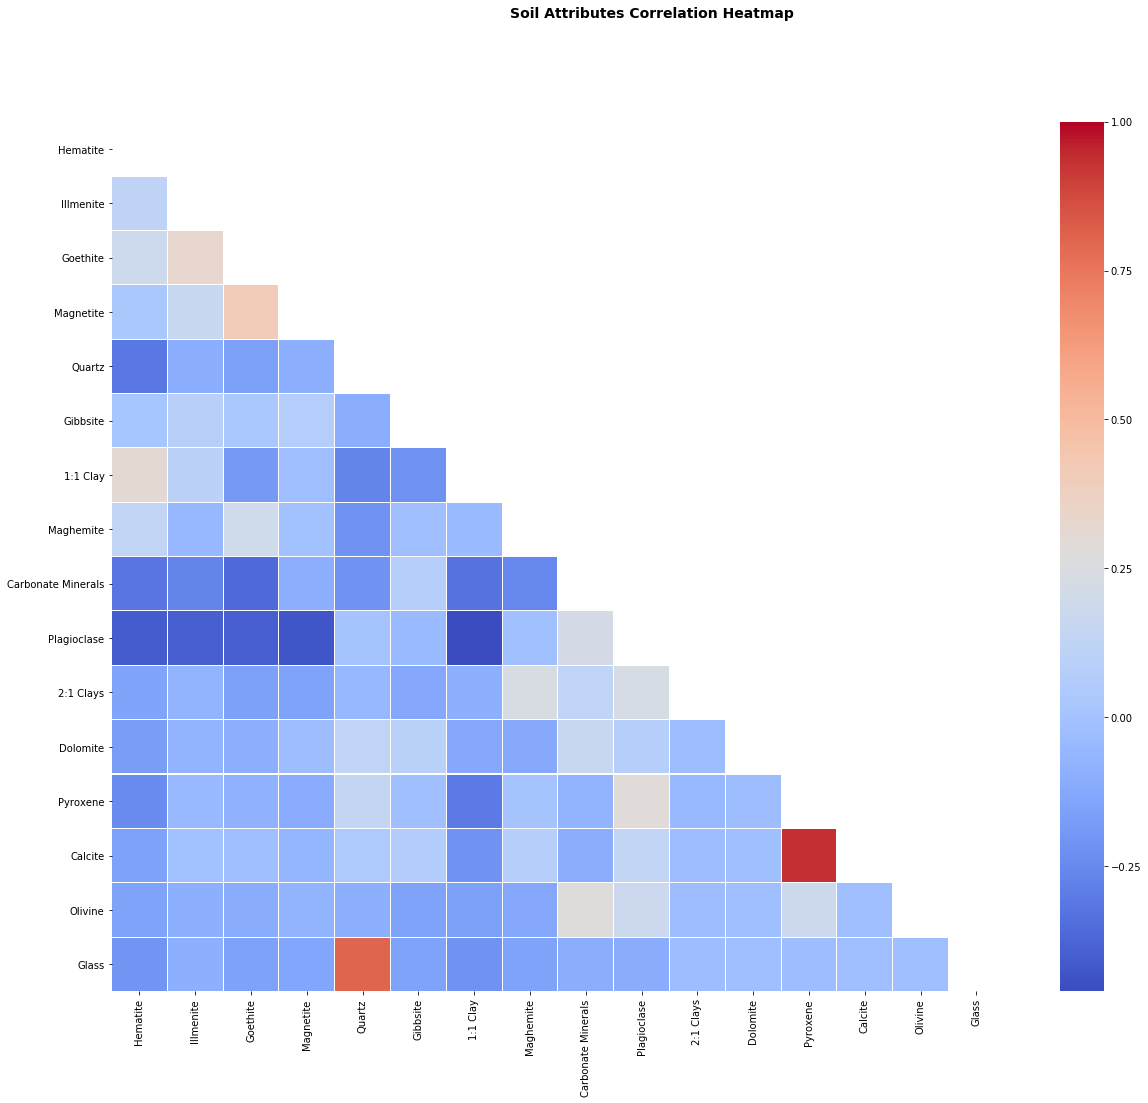

In [41]:
import seaborn as sns
import numpy as np
corr_matrix = soil_scaled.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, (ax) = plt.subplots(1, 1, figsize=(20,16))
hm = sns.heatmap(corr_matrix,
                 mask=mask,
                 ax=ax, # Axes in which to draw the plot, otherwise use the currently-active Axes.
                 cmap="coolwarm", # Color Map.
                 square=False,    # If True, set the Axes aspect to “equal” so each cell will be square-shaped.
                 annot=False, 
                 fmt='.2f',       # String formatting code to use when adding annotations.
                 #annot_kws={"size": 14},
                 linewidths=.05)
fig.suptitle('Soil Attributes Correlation Heatmap', 
              fontsize=14, 
              fontweight='bold')

#### Parallel Coordinates

In [4]:
plt.rc('legend',**{'fontsize':12})
from pandas.plotting import parallel_coordinates

The subsampled dataframe used in the visualizations below is created to balance the response variable NTM Culture. There are 11 positive cultures and 42 negative samples. The resulting dataframe is normalized to 11 in each category. 

In [5]:
grouped = soil_scaled.groupby('NTM Culture')
nmax = 11
import random
random.seed(1)
balanced = grouped.apply(lambda x: x.sample(nmax) if len(x) > nmax else x)

##### Subsampled Full

###### By NTM Culture

(array([-2.,  0.,  2.,  4.,  6.,  8.]), <a list of 6 Text yticklabel objects>)

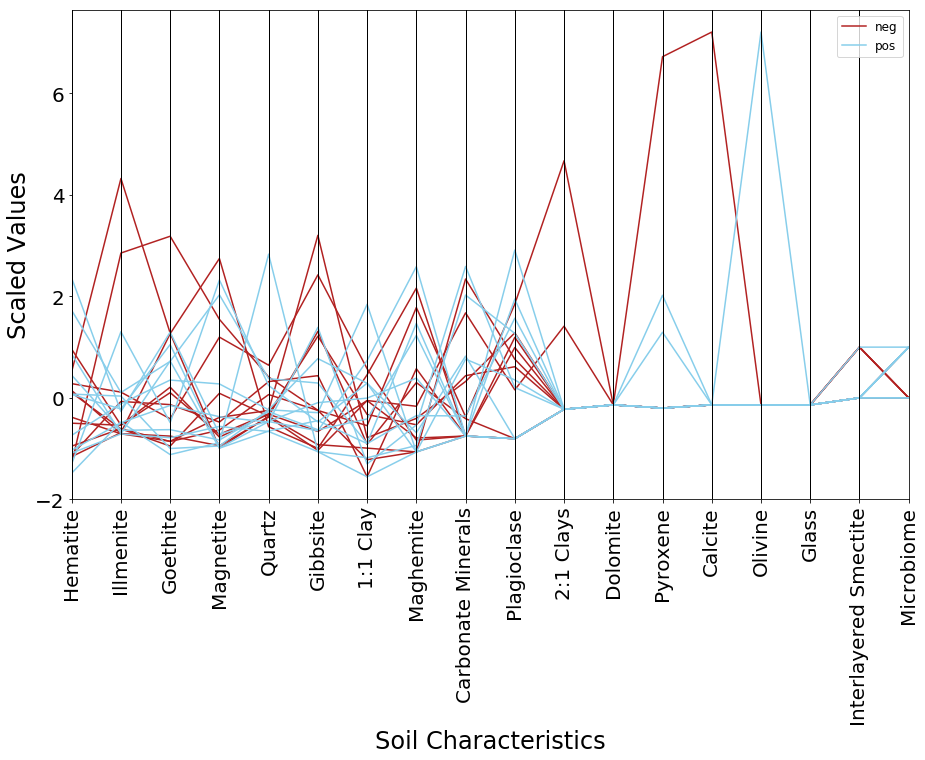

In [34]:
soil_scaled2 = balanced.drop("Group", axis=1)
pc = parallel_coordinates(soil_scaled2, 
                          'NTM Culture', 
                          color=('firebrick', 'skyblue'))
pc.set_xticklabels(pc.get_xticklabels(),rotation=90)
plt.grid(False)
plt.xlabel('Soil Characteristics', size = 24)
plt.ylabel('Scaled Values', size = 24)
plt.xticks(size = 20)
plt.yticks(size = 20)

##### By Group

(array([-2.,  0.,  2.,  4.,  6.,  8.]), <a list of 6 Text yticklabel objects>)

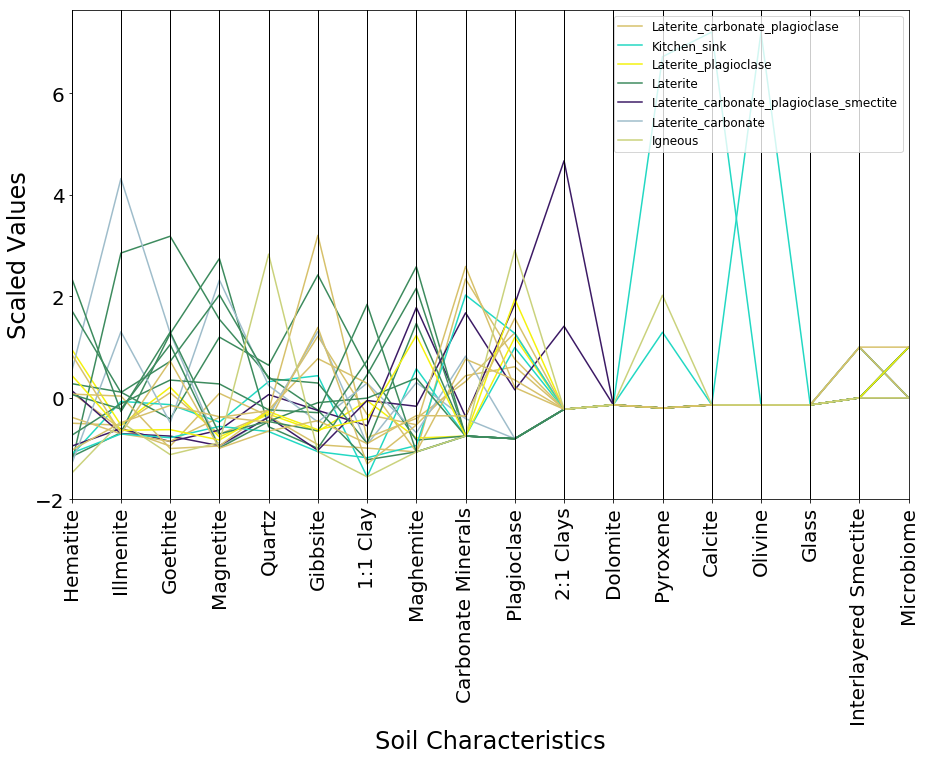

In [35]:
soil_scaled2 = balanced.drop("NTM Culture", axis=1)
pc = parallel_coordinates(soil_scaled2, 
                          'Group')
pc.set_xticklabels(pc.get_xticklabels(),rotation=90)
plt.grid(False)
plt.xlabel('Soil Characteristics', size = 24)
plt.ylabel('Scaled Values', size = 24)
plt.xticks(size = 20)
plt.yticks(size = 20)

##### By Interlayered Smectite

(array([-2.,  0.,  2.,  4.,  6.,  8.]), <a list of 6 Text yticklabel objects>)

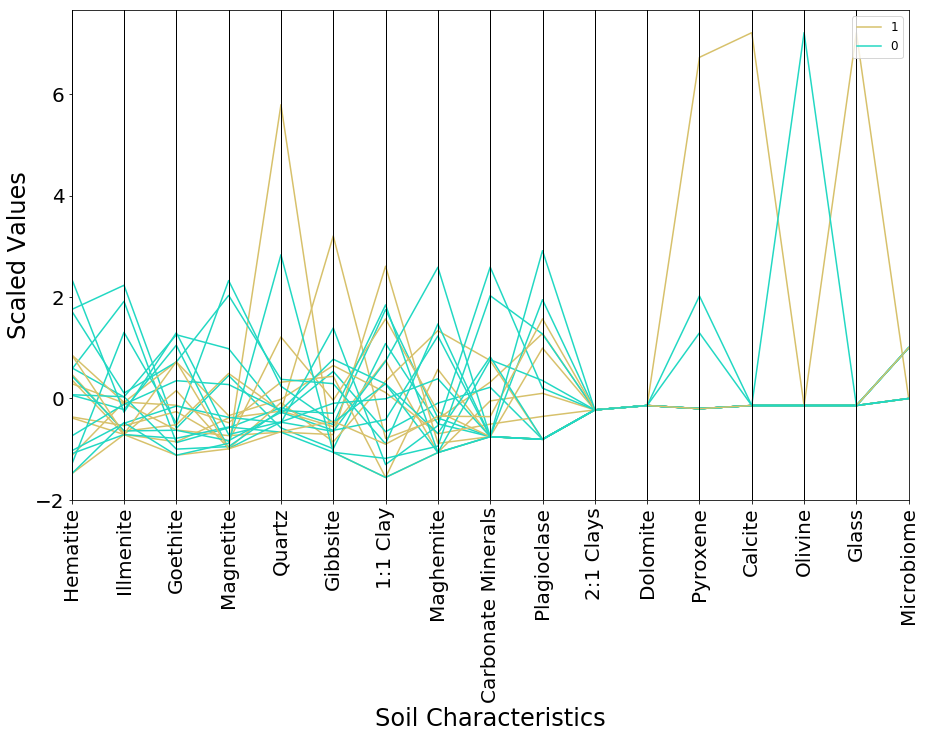

In [39]:
soil_scaled2 = balanced.drop(["NTM Culture", "Group"], axis=1)
pc = parallel_coordinates(soil_scaled2, 
                          'Interlayered Smectite')
pc.set_xticklabels(pc.get_xticklabels(),rotation=90)
plt.grid(False)
plt.xlabel('Soil Characteristics', size = 24)
plt.ylabel('Scaled Values', size = 24)
plt.xticks(size = 20)
plt.yticks(size = 20)

##### Subsampled Grouped Data

In [8]:
culture_std = balanced.groupby("NTM Culture").std()

culture_average = balanced.groupby('NTM Culture').mean()
culture_average['NTM Culture'] = culture_average.index
culture_average['NTM Culture'].replace(('pos', 'neg'), ('Positive Culture', 'Negative Culture'), inplace=True)


x_axis = list(culture_average.columns)
x_axis.pop()
x_axis = [str(x) for x in x_axis]

### means
negative_means = list(culture_average.iloc[0])
positive_means = list(culture_average.iloc[1])

negative_means.pop()
positive_means.pop()

negative_means = np.array(negative_means)
positive_means = np.array(positive_means)

### standard deviations
negative_std = np.array(culture_std.iloc[0])
positive_std = culture_std.iloc[1]

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 <a list of 16 Text xticklabel objects>)

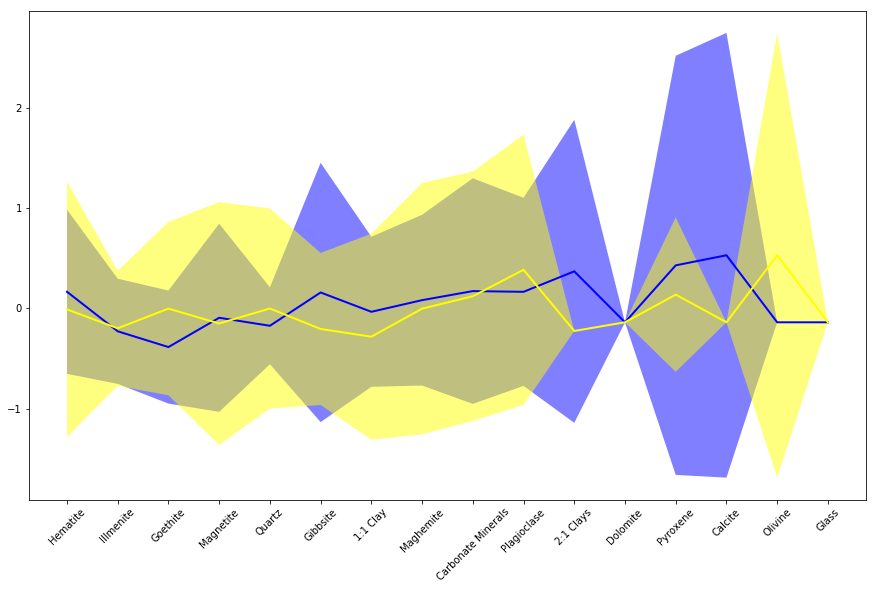

In [16]:
# plot it!
fig, ax = plt.subplots(1)
ax.plot(negative_means, lw=2, label='mean population 1', color='blue')
plt.fill_between(x_axis, negative_means+negative_std, negative_means-negative_std, facecolor='blue', alpha=0.5)

ax.plot(positive_means, lw=2, label='mean population 2', color='yellow')

plt.fill_between(x_axis, positive_means+positive_std, positive_means-positive_std, facecolor='yellow', alpha=0.5)

#ax.errorbar(x=culture_std.columns,y=negative_means, yerr=negative_std, fmt='-o')
#ax.add_line(negative_means-negative_std)

plt.xticks(rotation=45) 

In [ ]:
soil_scaled2 = soil_scaled.drop("NTM Culture", axis=1)
pc = parallel_coordinates(soil_scaled2, 
                          'Group')
pc.set_xticklabels(pc.get_xticklabels(),rotation=90)
plt.grid(False)
plt.xlabel('Soil Characteristics', size = 24)
plt.ylabel('Scaled Values', size = 24)
plt.xticks(size = 20)
plt.yticks(size = 20)

##### Full Data

###### By NTM Culture

(array([-2.,  0.,  2.,  4.,  6.,  8.]), <a list of 6 Text yticklabel objects>)

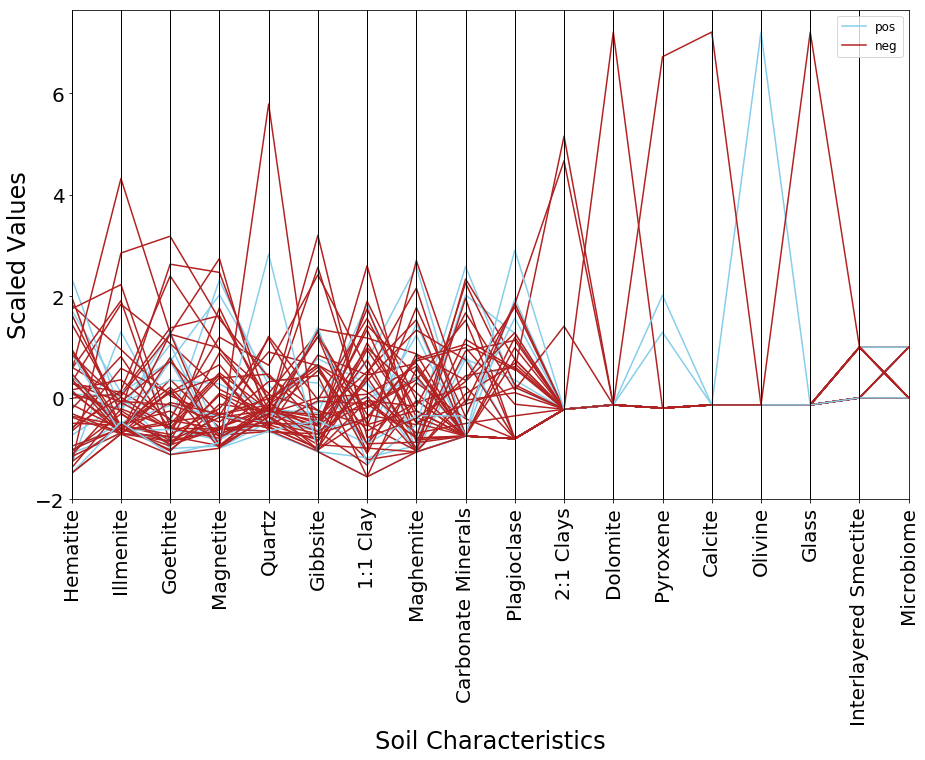

In [27]:
soil_scaled2 = soil_scaled.drop("Group", axis=1)
pc = parallel_coordinates(soil_scaled2, 
                          'NTM Culture', 
                          color=('skyblue', 'firebrick'))
pc.set_xticklabels(pc.get_xticklabels(),rotation=90)
plt.grid(False)
plt.xlabel('Soil Characteristics', size = 24)
plt.ylabel('Scaled Values', size = 24)
plt.xticks(size = 20)
plt.yticks(size = 20)

###### By Group

(array([-2.,  0.,  2.,  4.,  6.,  8.]), <a list of 6 Text yticklabel objects>)

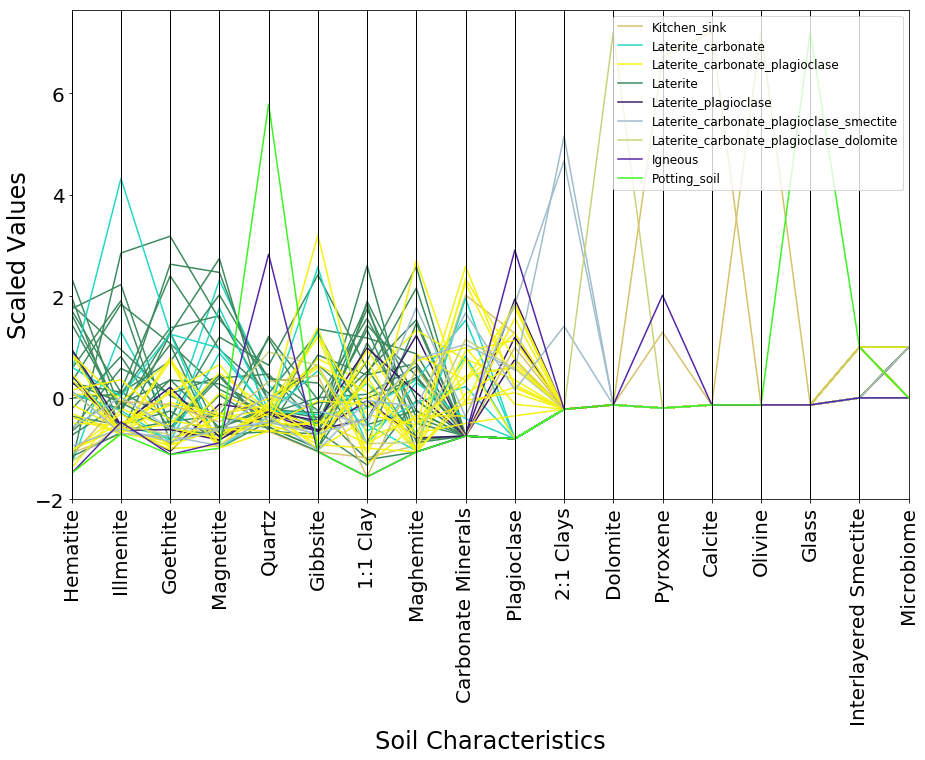

In [30]:
soil_scaled2 = soil_scaled.drop("NTM Culture", axis=1)
pc = parallel_coordinates(soil_scaled2, 
                          'Group')
pc.set_xticklabels(pc.get_xticklabels(),rotation=90)
plt.grid(False)
plt.xlabel('Soil Characteristics', size = 24)
plt.ylabel('Scaled Values', size = 24)
plt.xticks(size = 20)
plt.yticks(size = 20)

###### By Interlayered Smecite

(array([-2.,  0.,  2.,  4.,  6.,  8.]), <a list of 6 Text yticklabel objects>)

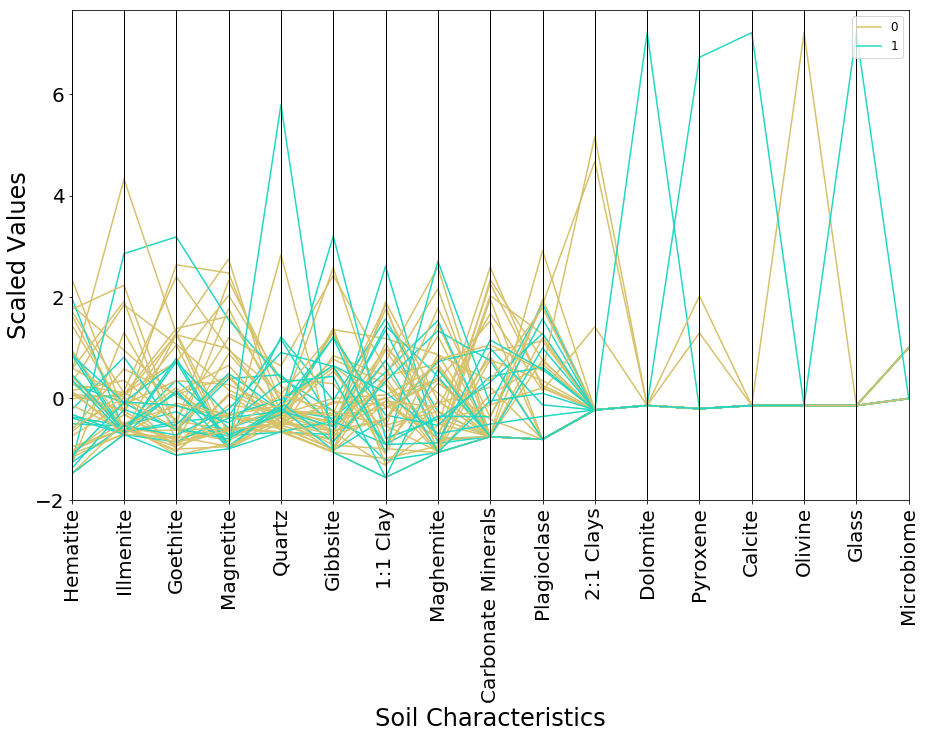

In [31]:
soil_scaled2 = soil_scaled.drop(["NTM Culture", "Group"], axis=1)
pc = parallel_coordinates(soil_scaled2, 
                          'Interlayered Smectite')
pc.set_xticklabels(pc.get_xticklabels(),rotation=90)
plt.grid(False)
plt.xlabel('Soil Characteristics', size = 24)
plt.ylabel('Scaled Values', size = 24)
plt.xticks(size = 20)
plt.yticks(size = 20)